# This file calculates the latent dimensions for 1354 model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import optimizers, models, regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, Input
from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout, GRU,SimpleRNN
from tensorflow.keras.layers import Flatten, Dense,Dropout
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from numpy.linalg import norm
from scipy import stats
import scipy.io as sio
def outliers(df, int):
  z_scores = stats.zscore(df)
  abs_z_scores = np.abs(z_scores)
  filtered_entries = (abs_z_scores < int).all(axis=1)
  df = df[filtered_entries]
  return df
def coeff_determination(y_pred, y_true): #Order of function inputs is important here        
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# importing data 

In [2]:
tspan=60
set=50
train= sio.loadmat('snaps_train.mat')   # load the desired model
snapshots_train=train['snaps_train'].T
test= sio.loadmat('snaps_test.mat')   # load the desired model
snapshots_all=test['snaps_test']
snapshots_valid=snapshots_all[0:tspan,:]
snapshots_test=snapshots_all[2*tspan:2*tspan+tspan,:]
snapshots_train=outliers(snapshots_train,10)
print(snapshots_train.shape)
print(snapshots_valid.shape)
print(snapshots_test.shape)

(3000, 2708)
(60, 2708)
(60, 2708)


# Defining the Autoencoder and training it

In [4]:
loop= np.arange(5,50,5)
loop

array([ 5, 10, 15, 20, 25, 30, 35, 40, 45])

In [5]:
Norm_delta=np.zeros(shape=(1,loop.shape[0]))
Norm_omega=np.zeros(shape=(1,loop.shape[0]))
d=int(snapshots_train.shape[1]/2)
sample=0
input=output=snapshots_train.shape[1]
first=input
second=2048
#third=256
# Encoder
weights_filepath = 'PODAE_weights_10.h5'
encoder_input = Input(shape=(input, 1), name='IEEE118')
o1 = Flatten()(encoder_input)
o2 = Dense(first, activation="relu")(o1)
o3 = Dense(second, activation="relu")(o2)
#o4 = Dense(third, activation="relu")(o3)
for i in range(len(loop)):
    print('Running testing for i =', i, ' of ',loop.shape[0])
    encoder_output = Dense(loop[i], activation=None)(o3)
    encoder = Model(encoder_input, encoder_output, name='encoder')
    #encoder.summary()
    # Decoder
    decoder_input = Dense(loop[i], activation='relu')(encoder_output)
   # decoder_input1 = Dense(third, activation='relu')(decoder_input)
    decoder_input2 = Dense(second, activation='relu')(decoder_input)
    decoder_input3= Dense(first, activation='relu')(decoder_input2)
    decoder_output = Dense(output, activation=None)(decoder_input3)
    decoder = Model(decoder_input, decoder_output, name='decoder')
    #decoder.summary()
    # defining autoencoder
    ae_output=decoder(encoder(encoder_input))
    autoencoder = Model(encoder_input, ae_output, name='autoencoder')
    # design network
    lrate = 0.001
    my_adam = optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

    checkpoint = ModelCheckpoint(weights_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
    earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    callbacks_list = [checkpoint]
    epoch_num=200
    batch_size=set
    autoencoder.compile(optimizer=my_adam, loss='MeanSquaredError',metrics=[coeff_determination,'accuracy'])
    autoencoder.fit(snapshots_train, snapshots_train,
                epochs=epoch_num,  batch_size=batch_size,callbacks=callbacks_list,
                          validation_data=(snapshots_valid, snapshots_valid))
              # # shuffle=True)
    # Testing the data
    autoencoder.load_weights(weights_filepath)
    #encoded_test = K.eval(encoder(snapshots_test.astype('float32')))
    autoencoder_output = autoencoder.predict(snapshots_test)
    Norm_delta[:,sample]=norm(snapshots_test[:,:d]-autoencoder_output[:,:d])/norm(snapshots_test[:,:d])
    Norm_omega[:,sample]=norm(snapshots_test[:,d:]-autoencoder_output[:,d:])/norm(snapshots_test[:,d:])
   # Norm_outputAE[:,sample]=norm(snapshots_test-autoencoder_output)/norm(snapshots_test)
    sample=sample+1

2022-07-20 16:11:33.305759: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-20 16:11:33.791902: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30987 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
/opt/apps/anaconda3/2020.11/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Running testing for i = 0  of  9
Epoch 1/200
59/60 [============================>.] - ETA: 0s - loss: 0.4362 - coeff_determination: -25.1441 - accuracy: 0.0946
Epoch 1: loss improved from inf to 0.43000, saving model to PODAE_weights_10.h5
60/60 [==============================] - 1s 11ms/step - loss: 0.4300 - coeff_determination: -24.7091 - accuracy: 0.0950 - val_loss: 0.0718 - val_coeff_determination: 0.8915 - val_accuracy: 0.4833
Epoch 2/200
60/60 [==============================] - ETA: 0s - loss: 0.0453 - coeff_determination: 0.9710 - accuracy: 0.4893
Epoch 2: loss improved from 0.43000 to 0.04526, saving model to PODAE_weights_10.h5
60/60 [==============================] - 1s 9ms/step - loss: 0.0453 - coeff_determination: 0.9710 - accuracy: 0.4893 - val_loss: 0.0234 - val_coeff_determination: 0.9658 - val_accuracy: 0.7167
Epoch 3/200
60/60 [==============================] - ETA: 0s - loss: 0.0237 - coeff_determination: 0.9852 - accuracy: 0.6340
Epoch 3: loss improved from 0.04526 t

60/60 [==============================] - ETA: 0s - loss: 0.0033 - coeff_determination: 0.9979 - accuracy: 0.8613
Epoch 44: loss did not improve from 0.00129
60/60 [==============================] - 0s 5ms/step - loss: 0.0033 - coeff_determination: 0.9979 - accuracy: 0.8613 - val_loss: 0.0046 - val_coeff_determination: 0.9925 - val_accuracy: 0.8833
Epoch 45/200
59/60 [============================>.] - ETA: 0s - loss: 0.0044 - coeff_determination: 0.9973 - accuracy: 0.8525
Epoch 45: loss did not improve from 0.00129
60/60 [==============================] - 0s 5ms/step - loss: 0.0044 - coeff_determination: 0.9973 - accuracy: 0.8530 - val_loss: 0.0023 - val_coeff_determination: 0.9963 - val_accuracy: 0.8833
Epoch 46/200
60/60 [==============================] - ETA: 0s - loss: 0.0038 - coeff_determination: 0.9977 - accuracy: 0.8617
Epoch 46: loss did not improve from 0.00129
60/60 [==============================] - 0s 5ms/step - loss: 0.0038 - coeff_determination: 0.9977 - accuracy: 0.8617 

60/60 [==============================] - 0s 5ms/step - loss: 0.0024 - coeff_determination: 0.9985 - accuracy: 0.8917 - val_loss: 0.0011 - val_coeff_determination: 0.9981 - val_accuracy: 0.9000
Epoch 88/200
49/60 [=======================>......] - ETA: 0s - loss: 0.0133 - coeff_determination: 0.9919 - accuracy: 0.8473
Epoch 88: loss did not improve from 0.00011
60/60 [==============================] - 0s 5ms/step - loss: 0.0240 - coeff_determination: 0.9849 - accuracy: 0.7963 - val_loss: 0.0360 - val_coeff_determination: 0.9539 - val_accuracy: 0.7000
Epoch 89/200
59/60 [============================>.] - ETA: 0s - loss: 0.0318 - coeff_determination: 0.9801 - accuracy: 0.6942
Epoch 89: loss did not improve from 0.00011
60/60 [==============================] - 0s 5ms/step - loss: 0.0314 - coeff_determination: 0.9803 - accuracy: 0.6930 - val_loss: 0.0091 - val_coeff_determination: 0.9876 - val_accuracy: 0.8333
Epoch 90/200
60/60 [==============================] - ETA: 0s - loss: 0.0079 - co

Epoch 131/200
60/60 [==============================] - ETA: 0s - loss: 8.8697e-04 - coeff_determination: 0.9994 - accuracy: 0.9410
Epoch 131: loss did not improve from 0.00011
60/60 [==============================] - 0s 5ms/step - loss: 8.8697e-04 - coeff_determination: 0.9994 - accuracy: 0.9410 - val_loss: 0.0014 - val_coeff_determination: 0.9983 - val_accuracy: 0.9500
Epoch 132/200
50/60 [========================>.....] - ETA: 0s - loss: 0.0028 - coeff_determination: 0.9982 - accuracy: 0.9212
Epoch 132: loss did not improve from 0.00011
60/60 [==============================] - 0s 5ms/step - loss: 0.0027 - coeff_determination: 0.9983 - accuracy: 0.9227 - val_loss: 0.0011 - val_coeff_determination: 0.9984 - val_accuracy: 0.9167
Epoch 133/200
60/60 [==============================] - ETA: 0s - loss: 0.0010 - coeff_determination: 0.9994 - accuracy: 0.9170    
Epoch 133: loss did not improve from 0.00011
60/60 [==============================] - 0s 5ms/step - loss: 0.0010 - coeff_determinat

Epoch 153/200
59/60 [============================>.] - ETA: 0s - loss: 9.4067e-05 - coeff_determination: 0.9999 - accuracy: 0.9553
Epoch 153: loss did not improve from 0.00008
60/60 [==============================] - 0s 5ms/step - loss: 9.5565e-05 - coeff_determination: 0.9999 - accuracy: 0.9547 - val_loss: 8.1555e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9500
Epoch 154/200
60/60 [==============================] - ETA: 0s - loss: 4.3077e-04 - coeff_determination: 0.9997 - accuracy: 0.9523
Epoch 154: loss did not improve from 0.00008
60/60 [==============================] - 0s 5ms/step - loss: 4.3077e-04 - coeff_determination: 0.9997 - accuracy: 0.9523 - val_loss: 4.1400e-04 - val_coeff_determination: 0.9995 - val_accuracy: 0.9500
Epoch 155/200
60/60 [==============================] - ETA: 0s - loss: 0.0075 - coeff_determination: 0.9954 - accuracy: 0.8873
Epoch 155: loss did not improve from 0.00008
60/60 [==============================] - 0s 5ms/step - loss: 0.0075 - coef

Epoch 175/200
59/60 [============================>.] - ETA: 0s - loss: 0.0031 - coeff_determination: 0.9981 - accuracy: 0.9125
Epoch 175: loss did not improve from 0.00008
60/60 [==============================] - 0s 5ms/step - loss: 0.0030 - coeff_determination: 0.9981 - accuracy: 0.9130 - val_loss: 6.2870e-04 - val_coeff_determination: 0.9993 - val_accuracy: 0.9500
Epoch 176/200
49/60 [=======================>......] - ETA: 0s - loss: 7.5468e-04 - coeff_determination: 0.9995 - accuracy: 0.9363
Epoch 176: loss did not improve from 0.00008
60/60 [==============================] - 0s 5ms/step - loss: 8.0248e-04 - coeff_determination: 0.9995 - accuracy: 0.9357 - val_loss: 4.8499e-04 - val_coeff_determination: 0.9993 - val_accuracy: 0.9667
Epoch 177/200
60/60 [==============================] - ETA: 0s - loss: 3.6133e-04 - coeff_determination: 0.9998 - accuracy: 0.9300
Epoch 177: loss did not improve from 0.00008
60/60 [==============================] - 0s 5ms/step - loss: 3.6133e-04 - coef

Epoch 197/200
60/60 [==============================] - ETA: 0s - loss: 2.9010e-04 - coeff_determination: 0.9998 - accuracy: 0.9530
Epoch 197: loss did not improve from 0.00008
60/60 [==============================] - 0s 5ms/step - loss: 2.9010e-04 - coeff_determination: 0.9998 - accuracy: 0.9530 - val_loss: 1.1313e-04 - val_coeff_determination: 0.9998 - val_accuracy: 0.9500
Epoch 198/200
49/60 [=======================>......] - ETA: 0s - loss: 2.3285e-04 - coeff_determination: 0.9999 - accuracy: 0.9502
Epoch 198: loss did not improve from 0.00008
60/60 [==============================] - 0s 5ms/step - loss: 2.4725e-04 - coeff_determination: 0.9998 - accuracy: 0.9483 - val_loss: 1.0207e-04 - val_coeff_determination: 0.9998 - val_accuracy: 0.9667
Epoch 199/200
49/60 [=======================>......] - ETA: 0s - loss: 0.0027 - coeff_determination: 0.9983 - accuracy: 0.9408
Epoch 199: loss did not improve from 0.00008
60/60 [==============================] - 0s 5ms/step - loss: 0.0027 - coef

Epoch 19/200
49/60 [=======================>......] - ETA: 0s - loss: 0.0027 - coeff_determination: 0.9983 - accuracy: 0.8567
Epoch 19: loss did not improve from 0.00115
60/60 [==============================] - 0s 5ms/step - loss: 0.0026 - coeff_determination: 0.9984 - accuracy: 0.8560 - val_loss: 0.0013 - val_coeff_determination: 0.9977 - val_accuracy: 0.9000
Epoch 20/200
58/60 [============================>.] - ETA: 0s - loss: 0.0011 - coeff_determination: 0.9993 - accuracy: 0.8869
Epoch 20: loss improved from 0.00115 to 0.00108, saving model to PODAE_weights_10.h5
60/60 [==============================] - 1s 9ms/step - loss: 0.0011 - coeff_determination: 0.9993 - accuracy: 0.8863 - val_loss: 4.5176e-04 - val_coeff_determination: 0.9990 - val_accuracy: 0.9333
Epoch 21/200
58/60 [============================>.] - ETA: 0s - loss: 6.6980e-04 - coeff_determination: 0.9996 - accuracy: 0.8983
Epoch 21: loss improved from 0.00108 to 0.00067, saving model to PODAE_weights_10.h5
60/60 [=======

Epoch 41/200
57/60 [===========================>..] - ETA: 0s - loss: 4.0414e-04 - coeff_determination: 0.9998 - accuracy: 0.9389
Epoch 41: loss did not improve from 0.00017
60/60 [==============================] - 0s 5ms/step - loss: 4.0681e-04 - coeff_determination: 0.9998 - accuracy: 0.9380 - val_loss: 2.1460e-04 - val_coeff_determination: 0.9997 - val_accuracy: 0.9833
Epoch 42/200
52/60 [=========================>....] - ETA: 0s - loss: 3.3196e-04 - coeff_determination: 0.9998 - accuracy: 0.9385
Epoch 42: loss did not improve from 0.00017
60/60 [==============================] - 0s 6ms/step - loss: 3.1477e-04 - coeff_determination: 0.9998 - accuracy: 0.9383 - val_loss: 1.0949e-04 - val_coeff_determination: 0.9998 - val_accuracy: 0.9667
Epoch 43/200
53/60 [=========================>....] - ETA: 0s - loss: 1.7267e-04 - coeff_determination: 0.9999 - accuracy: 0.9457
Epoch 43: loss did not improve from 0.00017
60/60 [==============================] - 0s 6ms/step - loss: 1.6961e-04 - co

Epoch 63/200
59/60 [============================>.] - ETA: 0s - loss: 7.5001e-04 - coeff_determination: 0.9995 - accuracy: 0.9288
Epoch 63: loss did not improve from 0.00015
60/60 [==============================] - 0s 5ms/step - loss: 7.4886e-04 - coeff_determination: 0.9995 - accuracy: 0.9283 - val_loss: 4.8302e-04 - val_coeff_determination: 0.9989 - val_accuracy: 0.9500
Epoch 64/200
59/60 [============================>.] - ETA: 0s - loss: 0.0016 - coeff_determination: 0.9990 - accuracy: 0.9295
Epoch 64: loss did not improve from 0.00015
60/60 [==============================] - 0s 5ms/step - loss: 0.0016 - coeff_determination: 0.9990 - accuracy: 0.9283 - val_loss: 9.4565e-04 - val_coeff_determination: 0.9986 - val_accuracy: 0.9500
Epoch 65/200
60/60 [==============================] - ETA: 0s - loss: 9.8794e-04 - coeff_determination: 0.9994 - accuracy: 0.9300
Epoch 65: loss did not improve from 0.00015
60/60 [==============================] - 0s 5ms/step - loss: 9.8794e-04 - coeff_dete

Epoch 85/200
49/60 [=======================>......] - ETA: 0s - loss: 0.0063 - coeff_determination: 0.9961 - accuracy: 0.9073
Epoch 85: loss did not improve from 0.00015
60/60 [==============================] - 0s 5ms/step - loss: 0.0073 - coeff_determination: 0.9955 - accuracy: 0.9050 - val_loss: 0.0034 - val_coeff_determination: 0.9949 - val_accuracy: 0.9333
Epoch 86/200
49/60 [=======================>......] - ETA: 0s - loss: 0.0059 - coeff_determination: 0.9964 - accuracy: 0.8906
Epoch 86: loss did not improve from 0.00015
60/60 [==============================] - 0s 5ms/step - loss: 0.0058 - coeff_determination: 0.9964 - accuracy: 0.8890 - val_loss: 0.0020 - val_coeff_determination: 0.9971 - val_accuracy: 0.9167
Epoch 87/200
49/60 [=======================>......] - ETA: 0s - loss: 0.0075 - coeff_determination: 0.9954 - accuracy: 0.8686
Epoch 87: loss did not improve from 0.00015
60/60 [==============================] - 0s 5ms/step - loss: 0.0069 - coeff_determination: 0.9958 - accu

Epoch 107/200
49/60 [=======================>......] - ETA: 0s - loss: 5.1066e-04 - coeff_determination: 0.9997 - accuracy: 0.9290
Epoch 107: loss did not improve from 0.00005
60/60 [==============================] - 0s 5ms/step - loss: 4.7775e-04 - coeff_determination: 0.9997 - accuracy: 0.9293 - val_loss: 2.1722e-04 - val_coeff_determination: 0.9997 - val_accuracy: 0.9333
Epoch 108/200
59/60 [============================>.] - ETA: 0s - loss: 3.6407e-04 - coeff_determination: 0.9998 - accuracy: 0.9380
Epoch 108: loss did not improve from 0.00005
60/60 [==============================] - 0s 5ms/step - loss: 3.6386e-04 - coeff_determination: 0.9998 - accuracy: 0.9380 - val_loss: 4.7086e-04 - val_coeff_determination: 0.9993 - val_accuracy: 0.9500
Epoch 109/200
60/60 [==============================] - ETA: 0s - loss: 6.8214e-04 - coeff_determination: 0.9996 - accuracy: 0.9337
Epoch 109: loss did not improve from 0.00005
60/60 [==============================] - 0s 5ms/step - loss: 6.8214e-0

Epoch 129/200
60/60 [==============================] - ETA: 0s - loss: 2.6127e-04 - coeff_determination: 0.9998 - accuracy: 0.9437
Epoch 129: loss did not improve from 0.00005
60/60 [==============================] - 0s 5ms/step - loss: 2.6127e-04 - coeff_determination: 0.9998 - accuracy: 0.9437 - val_loss: 4.2034e-04 - val_coeff_determination: 0.9993 - val_accuracy: 0.9500
Epoch 130/200
58/60 [============================>.] - ETA: 0s - loss: 3.6115e-04 - coeff_determination: 0.9998 - accuracy: 0.9428
Epoch 130: loss did not improve from 0.00005
60/60 [==============================] - 0s 5ms/step - loss: 3.7029e-04 - coeff_determination: 0.9998 - accuracy: 0.9437 - val_loss: 2.7392e-04 - val_coeff_determination: 0.9996 - val_accuracy: 0.9333
Epoch 131/200
60/60 [==============================] - ETA: 0s - loss: 3.0407e-04 - coeff_determination: 0.9998 - accuracy: 0.9423
Epoch 131: loss did not improve from 0.00005
60/60 [==============================] - 0s 5ms/step - loss: 3.0407e-0

Epoch 151/200
53/60 [=========================>....] - ETA: 0s - loss: 2.5724e-04 - coeff_determination: 0.9998 - accuracy: 0.9517
Epoch 151: loss did not improve from 0.00005
60/60 [==============================] - 0s 6ms/step - loss: 2.3961e-04 - coeff_determination: 0.9999 - accuracy: 0.9537 - val_loss: 5.9782e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9500
Epoch 152/200
60/60 [==============================] - ETA: 0s - loss: 8.4730e-05 - coeff_determination: 0.9999 - accuracy: 0.9607
Epoch 152: loss did not improve from 0.00005
60/60 [==============================] - 0s 5ms/step - loss: 8.4730e-05 - coeff_determination: 0.9999 - accuracy: 0.9607 - val_loss: 6.5144e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9333
Epoch 153/200
49/60 [=======================>......] - ETA: 0s - loss: 1.2328e-04 - coeff_determination: 0.9999 - accuracy: 0.9584
Epoch 153: loss did not improve from 0.00005
60/60 [==============================] - 0s 5ms/step - loss: 1.2069e-0

Epoch 173/200
49/60 [=======================>......] - ETA: 0s - loss: 2.3455e-04 - coeff_determination: 0.9999 - accuracy: 0.9510
Epoch 173: loss did not improve from 0.00005
60/60 [==============================] - 0s 5ms/step - loss: 2.8197e-04 - coeff_determination: 0.9998 - accuracy: 0.9497 - val_loss: 3.2159e-04 - val_coeff_determination: 0.9996 - val_accuracy: 0.9833
Epoch 174/200
59/60 [============================>.] - ETA: 0s - loss: 0.0027 - coeff_determination: 0.9983 - accuracy: 0.9400
Epoch 174: loss did not improve from 0.00005
60/60 [==============================] - 0s 5ms/step - loss: 0.0027 - coeff_determination: 0.9983 - accuracy: 0.9383 - val_loss: 0.0055 - val_coeff_determination: 0.9940 - val_accuracy: 0.8833
Epoch 175/200
57/60 [===========================>..] - ETA: 0s - loss: 0.0046 - coeff_determination: 0.9971 - accuracy: 0.8926
Epoch 175: loss did not improve from 0.00005
60/60 [==============================] - 0s 5ms/step - loss: 0.0045 - coeff_determinat

Epoch 195/200
60/60 [==============================] - ETA: 0s - loss: 2.2338e-04 - coeff_determination: 0.9999 - accuracy: 0.9467
Epoch 195: loss did not improve from 0.00003
60/60 [==============================] - 0s 5ms/step - loss: 2.2338e-04 - coeff_determination: 0.9999 - accuracy: 0.9467 - val_loss: 1.1963e-04 - val_coeff_determination: 0.9998 - val_accuracy: 0.9833
Epoch 196/200
60/60 [==============================] - ETA: 0s - loss: 2.0774e-04 - coeff_determination: 0.9999 - accuracy: 0.9507
Epoch 196: loss did not improve from 0.00003
60/60 [==============================] - 0s 5ms/step - loss: 2.0774e-04 - coeff_determination: 0.9999 - accuracy: 0.9507 - val_loss: 1.2464e-04 - val_coeff_determination: 0.9998 - val_accuracy: 0.9833
Epoch 197/200
49/60 [=======================>......] - ETA: 0s - loss: 1.1063e-04 - coeff_determination: 0.9999 - accuracy: 0.9498
Epoch 197: loss did not improve from 0.00003
60/60 [==============================] - 0s 5ms/step - loss: 1.0458e-0

Epoch 38/200
49/60 [=======================>......] - ETA: 0s - loss: 0.0018 - coeff_determination: 0.9989 - accuracy: 0.9171  
Epoch 38: loss did not improve from 0.00030
60/60 [==============================] - 0s 5ms/step - loss: 0.0028 - coeff_determination: 0.9983 - accuracy: 0.9160 - val_loss: 0.0039 - val_coeff_determination: 0.9932 - val_accuracy: 0.8333
Epoch 39/200
49/60 [=======================>......] - ETA: 0s - loss: 0.0057 - coeff_determination: 0.9965 - accuracy: 0.8853
Epoch 39: loss did not improve from 0.00030
60/60 [==============================] - 0s 5ms/step - loss: 0.0050 - coeff_determination: 0.9969 - accuracy: 0.8907 - val_loss: 7.7398e-04 - val_coeff_determination: 0.9988 - val_accuracy: 0.9167
Epoch 40/200
60/60 [==============================] - ETA: 0s - loss: 8.3352e-04 - coeff_determination: 0.9995 - accuracy: 0.9157
Epoch 40: loss did not improve from 0.00030
60/60 [==============================] - 0s 5ms/step - loss: 8.3352e-04 - coeff_determination:

Epoch 60/200
52/60 [=========================>....] - ETA: 0s - loss: 0.0038 - coeff_determination: 0.9977 - accuracy: 0.8827
Epoch 60: loss did not improve from 0.00017
60/60 [==============================] - 0s 6ms/step - loss: 0.0037 - coeff_determination: 0.9978 - accuracy: 0.8857 - val_loss: 9.1566e-04 - val_coeff_determination: 0.9989 - val_accuracy: 0.9000
Epoch 61/200
53/60 [=========================>....] - ETA: 0s - loss: 9.5564e-04 - coeff_determination: 0.9994 - accuracy: 0.9260
Epoch 61: loss did not improve from 0.00017
60/60 [==============================] - 0s 6ms/step - loss: 9.2481e-04 - coeff_determination: 0.9994 - accuracy: 0.9260 - val_loss: 4.1317e-04 - val_coeff_determination: 0.9995 - val_accuracy: 0.9500
Epoch 62/200
53/60 [=========================>....] - ETA: 0s - loss: 3.0120e-04 - coeff_determination: 0.9998 - accuracy: 0.9415
Epoch 62: loss did not improve from 0.00017
60/60 [==============================] - 0s 6ms/step - loss: 3.0219e-04 - coeff_dete

Epoch 82/200
49/60 [=======================>......] - ETA: 0s - loss: 1.6521e-04 - coeff_determination: 0.9999 - accuracy: 0.9522
Epoch 82: loss did not improve from 0.00013
60/60 [==============================] - 0s 5ms/step - loss: 1.6847e-04 - coeff_determination: 0.9999 - accuracy: 0.9523 - val_loss: 1.1387e-04 - val_coeff_determination: 0.9998 - val_accuracy: 0.9500
Epoch 83/200
60/60 [==============================] - ETA: 0s - loss: 2.3436e-04 - coeff_determination: 0.9999 - accuracy: 0.9530
Epoch 83: loss did not improve from 0.00013
60/60 [==============================] - 0s 5ms/step - loss: 2.3436e-04 - coeff_determination: 0.9999 - accuracy: 0.9530 - val_loss: 8.1758e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9333
Epoch 84/200
56/60 [===========================>..] - ETA: 0s - loss: 1.8419e-04 - coeff_determination: 0.9999 - accuracy: 0.9446
Epoch 84: loss did not improve from 0.00013
60/60 [==============================] - 0s 5ms/step - loss: 1.8676e-04 - co

56/60 [===========================>..] - ETA: 0s - loss: 0.0029 - coeff_determination: 0.9982 - accuracy: 0.9079
Epoch 104: loss did not improve from 0.00012
60/60 [==============================] - 0s 5ms/step - loss: 0.0029 - coeff_determination: 0.9982 - accuracy: 0.9113 - val_loss: 0.0027 - val_coeff_determination: 0.9967 - val_accuracy: 0.9333
Epoch 105/200
49/60 [=======================>......] - ETA: 0s - loss: 0.0048 - coeff_determination: 0.9970 - accuracy: 0.8922
Epoch 105: loss did not improve from 0.00012
60/60 [==============================] - 0s 5ms/step - loss: 0.0050 - coeff_determination: 0.9969 - accuracy: 0.8883 - val_loss: 0.0035 - val_coeff_determination: 0.9958 - val_accuracy: 0.9000
Epoch 106/200
60/60 [==============================] - ETA: 0s - loss: 0.0020 - coeff_determination: 0.9988 - accuracy: 0.9153
Epoch 106: loss did not improve from 0.00012
60/60 [==============================] - 0s 5ms/step - loss: 0.0020 - coeff_determination: 0.9988 - accuracy: 0.

Epoch 126/200
60/60 [==============================] - ETA: 0s - loss: 0.0059 - coeff_determination: 0.9964 - accuracy: 0.8930
Epoch 126: loss did not improve from 0.00005
60/60 [==============================] - 0s 5ms/step - loss: 0.0059 - coeff_determination: 0.9964 - accuracy: 0.8930 - val_loss: 0.0036 - val_coeff_determination: 0.9929 - val_accuracy: 0.8333
Epoch 127/200
59/60 [============================>.] - ETA: 0s - loss: 0.0075 - coeff_determination: 0.9954 - accuracy: 0.8603
Epoch 127: loss did not improve from 0.00005
60/60 [==============================] - 0s 5ms/step - loss: 0.0077 - coeff_determination: 0.9953 - accuracy: 0.8593 - val_loss: 0.0120 - val_coeff_determination: 0.9849 - val_accuracy: 0.8333
Epoch 128/200
59/60 [============================>.] - ETA: 0s - loss: 0.0108 - coeff_determination: 0.9933 - accuracy: 0.8634
Epoch 128: loss did not improve from 0.00005
60/60 [==============================] - 0s 5ms/step - loss: 0.0107 - coeff_determination: 0.9934 

Epoch 148/200
49/60 [=======================>......] - ETA: 0s - loss: 1.1068e-04 - coeff_determination: 0.9999 - accuracy: 0.9547
Epoch 148: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 1.0125e-04 - coeff_determination: 0.9999 - accuracy: 0.9570 - val_loss: 3.2467e-05 - val_coeff_determination: 1.0000 - val_accuracy: 0.9667
Epoch 149/200
60/60 [==============================] - ETA: 0s - loss: 5.1270e-05 - coeff_determination: 1.0000 - accuracy: 0.9640
Epoch 149: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 5.1270e-05 - coeff_determination: 1.0000 - accuracy: 0.9640 - val_loss: 3.5320e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9667
Epoch 150/200
56/60 [===========================>..] - ETA: 0s - loss: 4.4250e-05 - coeff_determination: 1.0000 - accuracy: 0.9632
Epoch 150: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 4.3585e-0

Epoch 170/200
54/60 [==========================>...] - ETA: 0s - loss: 9.3992e-04 - coeff_determination: 0.9994 - accuracy: 0.9441
Epoch 170: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 9.7929e-04 - coeff_determination: 0.9994 - accuracy: 0.9450 - val_loss: 4.6123e-04 - val_coeff_determination: 0.9993 - val_accuracy: 0.9333
Epoch 171/200
58/60 [============================>.] - ETA: 0s - loss: 0.0025 - coeff_determination: 0.9984 - accuracy: 0.9255
Epoch 171: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 0.0025 - coeff_determination: 0.9984 - accuracy: 0.9233 - val_loss: 0.0017 - val_coeff_determination: 0.9979 - val_accuracy: 0.9000
Epoch 172/200
53/60 [=========================>....] - ETA: 0s - loss: 0.0021 - coeff_determination: 0.9987 - accuracy: 0.9189
Epoch 172: loss did not improve from 0.00004
60/60 [==============================] - 0s 6ms/step - loss: 0.0020 - coeff_determinat

Epoch 192/200
55/60 [==========================>...] - ETA: 0s - loss: 5.0415e-05 - coeff_determination: 1.0000 - accuracy: 0.9644
Epoch 192: loss did not improve from 0.00004
60/60 [==============================] - 0s 6ms/step - loss: 4.9859e-05 - coeff_determination: 1.0000 - accuracy: 0.9650 - val_loss: 2.6564e-05 - val_coeff_determination: 1.0000 - val_accuracy: 0.9833
Epoch 193/200
53/60 [=========================>....] - ETA: 0s - loss: 6.8242e-05 - coeff_determination: 1.0000 - accuracy: 0.9687
Epoch 193: loss did not improve from 0.00004
60/60 [==============================] - 0s 7ms/step - loss: 6.6841e-05 - coeff_determination: 1.0000 - accuracy: 0.9677 - val_loss: 4.8862e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9667
Epoch 194/200
54/60 [==========================>...] - ETA: 0s - loss: 4.3199e-05 - coeff_determination: 1.0000 - accuracy: 0.9648
Epoch 194: loss improved from 0.00004 to 0.00004, saving model to PODAE_weights_10.h5
60/60 [======================

Epoch 13/200
49/60 [=======================>......] - ETA: 0s - loss: 5.5510e-04 - coeff_determination: 0.9997 - accuracy: 0.9159
Epoch 13: loss did not improve from 0.00043
60/60 [==============================] - 0s 5ms/step - loss: 5.2834e-04 - coeff_determination: 0.9997 - accuracy: 0.9167 - val_loss: 3.3124e-04 - val_coeff_determination: 0.9994 - val_accuracy: 0.9667
Epoch 14/200
59/60 [============================>.] - ETA: 0s - loss: 4.8183e-04 - coeff_determination: 0.9997 - accuracy: 0.9115
Epoch 14: loss did not improve from 0.00043
60/60 [==============================] - 0s 5ms/step - loss: 4.7757e-04 - coeff_determination: 0.9997 - accuracy: 0.9130 - val_loss: 2.7993e-04 - val_coeff_determination: 0.9995 - val_accuracy: 0.9667
Epoch 15/200
60/60 [==============================] - ETA: 0s - loss: 8.8189e-04 - coeff_determination: 0.9995 - accuracy: 0.9137
Epoch 15: loss did not improve from 0.00043
60/60 [==============================] - 0s 5ms/step - loss: 8.8189e-04 - co

49/60 [=======================>......] - ETA: 0s - loss: 0.0023 - coeff_determination: 0.9986 - accuracy: 0.8971
Epoch 35: loss did not improve from 0.00038
60/60 [==============================] - 0s 5ms/step - loss: 0.0023 - coeff_determination: 0.9986 - accuracy: 0.8997 - val_loss: 7.7967e-04 - val_coeff_determination: 0.9989 - val_accuracy: 0.9167
Epoch 36/200
57/60 [===========================>..] - ETA: 0s - loss: 8.1281e-04 - coeff_determination: 0.9995 - accuracy: 0.9130
Epoch 36: loss did not improve from 0.00038
60/60 [==============================] - 0s 5ms/step - loss: 8.2261e-04 - coeff_determination: 0.9995 - accuracy: 0.9133 - val_loss: 6.9093e-04 - val_coeff_determination: 0.9991 - val_accuracy: 0.9500
Epoch 37/200
60/60 [==============================] - ETA: 0s - loss: 0.0017 - coeff_determination: 0.9990 - accuracy: 0.9213
Epoch 37: loss did not improve from 0.00038
60/60 [==============================] - 0s 5ms/step - loss: 0.0017 - coeff_determination: 0.9990 - a

Epoch 79/200
49/60 [=======================>......] - ETA: 0s - loss: 6.9698e-04 - coeff_determination: 0.9996 - accuracy: 0.9392
Epoch 79: loss did not improve from 0.00007
60/60 [==============================] - 0s 5ms/step - loss: 7.4276e-04 - coeff_determination: 0.9995 - accuracy: 0.9377 - val_loss: 0.0011 - val_coeff_determination: 0.9983 - val_accuracy: 0.9667
Epoch 80/200
59/60 [============================>.] - ETA: 0s - loss: 0.0085 - coeff_determination: 0.9947 - accuracy: 0.8542
Epoch 80: loss did not improve from 0.00007
60/60 [==============================] - 0s 5ms/step - loss: 0.0085 - coeff_determination: 0.9947 - accuracy: 0.8547 - val_loss: 0.0024 - val_coeff_determination: 0.9966 - val_accuracy: 0.9000
Epoch 81/200
49/60 [=======================>......] - ETA: 0s - loss: 0.0044 - coeff_determination: 0.9973 - accuracy: 0.9008
Epoch 81: loss did not improve from 0.00007
60/60 [==============================] - 0s 5ms/step - loss: 0.0044 - coeff_determination: 0.997

60/60 [==============================] - ETA: 0s - loss: 0.0016 - coeff_determination: 0.9990 - accuracy: 0.9310
Epoch 101: loss did not improve from 0.00007
60/60 [==============================] - 0s 5ms/step - loss: 0.0016 - coeff_determination: 0.9990 - accuracy: 0.9310 - val_loss: 0.0015 - val_coeff_determination: 0.9983 - val_accuracy: 0.9333
Epoch 102/200
49/60 [=======================>......] - ETA: 0s - loss: 0.0053 - coeff_determination: 0.9968 - accuracy: 0.9041
Epoch 102: loss did not improve from 0.00007
60/60 [==============================] - 0s 5ms/step - loss: 0.0049 - coeff_determination: 0.9970 - accuracy: 0.9033 - val_loss: 0.0021 - val_coeff_determination: 0.9973 - val_accuracy: 0.9333
Epoch 103/200
60/60 [==============================] - ETA: 0s - loss: 0.0035 - coeff_determination: 0.9979 - accuracy: 0.9010
Epoch 103: loss did not improve from 0.00007
60/60 [==============================] - 0s 5ms/step - loss: 0.0035 - coeff_determination: 0.9979 - accuracy: 0.

59/60 [============================>.] - ETA: 0s - loss: 4.2368e-04 - coeff_determination: 0.9997 - accuracy: 0.9458
Epoch 123: loss did not improve from 0.00007
60/60 [==============================] - 0s 5ms/step - loss: 4.2029e-04 - coeff_determination: 0.9997 - accuracy: 0.9463 - val_loss: 1.8966e-04 - val_coeff_determination: 0.9997 - val_accuracy: 0.9833
Epoch 124/200
60/60 [==============================] - ETA: 0s - loss: 2.8073e-04 - coeff_determination: 0.9998 - accuracy: 0.9523
Epoch 124: loss did not improve from 0.00007
60/60 [==============================] - 0s 5ms/step - loss: 2.8073e-04 - coeff_determination: 0.9998 - accuracy: 0.9523 - val_loss: 2.0940e-04 - val_coeff_determination: 0.9997 - val_accuracy: 0.9833
Epoch 125/200
49/60 [=======================>......] - ETA: 0s - loss: 8.3056e-04 - coeff_determination: 0.9995 - accuracy: 0.9453
Epoch 125: loss did not improve from 0.00007
60/60 [==============================] - 0s 5ms/step - loss: 7.8814e-04 - coeff_dete

Epoch 145/200
57/60 [===========================>..] - ETA: 0s - loss: 3.5644e-04 - coeff_determination: 0.9998 - accuracy: 0.9551
Epoch 145: loss did not improve from 0.00005
60/60 [==============================] - 0s 5ms/step - loss: 3.6632e-04 - coeff_determination: 0.9998 - accuracy: 0.9547 - val_loss: 2.0106e-04 - val_coeff_determination: 0.9997 - val_accuracy: 0.9333
Epoch 146/200
59/60 [============================>.] - ETA: 0s - loss: 0.0027 - coeff_determination: 0.9984 - accuracy: 0.9390
Epoch 146: loss did not improve from 0.00005
60/60 [==============================] - 0s 5ms/step - loss: 0.0027 - coeff_determination: 0.9984 - accuracy: 0.9373 - val_loss: 0.0024 - val_coeff_determination: 0.9965 - val_accuracy: 0.9333
Epoch 147/200
52/60 [=========================>....] - ETA: 0s - loss: 0.0061 - coeff_determination: 0.9963 - accuracy: 0.8738
Epoch 147: loss did not improve from 0.00005
60/60 [==============================] - 0s 6ms/step - loss: 0.0057 - coeff_determinat

Epoch 167/200
49/60 [=======================>......] - ETA: 0s - loss: 2.0748e-04 - coeff_determination: 0.9999 - accuracy: 0.9592
Epoch 167: loss did not improve from 0.00002
60/60 [==============================] - 0s 5ms/step - loss: 2.3240e-04 - coeff_determination: 0.9999 - accuracy: 0.9607 - val_loss: 2.0783e-04 - val_coeff_determination: 0.9997 - val_accuracy: 0.9333
Epoch 168/200
60/60 [==============================] - ETA: 0s - loss: 2.9147e-04 - coeff_determination: 0.9998 - accuracy: 0.9580
Epoch 168: loss did not improve from 0.00002
60/60 [==============================] - 0s 5ms/step - loss: 2.9147e-04 - coeff_determination: 0.9998 - accuracy: 0.9580 - val_loss: 2.1865e-04 - val_coeff_determination: 0.9997 - val_accuracy: 0.9500
Epoch 169/200
59/60 [============================>.] - ETA: 0s - loss: 2.1586e-04 - coeff_determination: 0.9999 - accuracy: 0.9620
Epoch 169: loss did not improve from 0.00002
60/60 [==============================] - 0s 5ms/step - loss: 2.1381e-0

Epoch 189/200
49/60 [=======================>......] - ETA: 0s - loss: 2.8410e-05 - coeff_determination: 1.0000 - accuracy: 0.9576
Epoch 189: loss did not improve from 0.00002
60/60 [==============================] - 0s 5ms/step - loss: 3.0371e-05 - coeff_determination: 1.0000 - accuracy: 0.9593 - val_loss: 2.9853e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9500
Epoch 190/200
60/60 [==============================] - ETA: 0s - loss: 4.6131e-05 - coeff_determination: 1.0000 - accuracy: 0.9603
Epoch 190: loss did not improve from 0.00002
60/60 [==============================] - 0s 5ms/step - loss: 4.6131e-05 - coeff_determination: 1.0000 - accuracy: 0.9603 - val_loss: 2.1551e-05 - val_coeff_determination: 1.0000 - val_accuracy: 0.9667
Epoch 191/200
58/60 [============================>.] - ETA: 0s - loss: 4.3384e-05 - coeff_determination: 1.0000 - accuracy: 0.9600
Epoch 191: loss did not improve from 0.00002
60/60 [==============================] - 0s 5ms/step - loss: 4.4549e-0

Epoch 10/200
59/60 [============================>.] - ETA: 0s - loss: 8.5405e-04 - coeff_determination: 0.9995 - accuracy: 0.9092
Epoch 10: loss did not improve from 0.00055
60/60 [==============================] - 0s 5ms/step - loss: 8.6509e-04 - coeff_determination: 0.9995 - accuracy: 0.9090 - val_loss: 5.7240e-04 - val_coeff_determination: 0.9990 - val_accuracy: 0.9333
Epoch 11/200
59/60 [============================>.] - ETA: 0s - loss: 0.0011 - coeff_determination: 0.9993 - accuracy: 0.8983
Epoch 11: loss did not improve from 0.00055
60/60 [==============================] - 0s 5ms/step - loss: 0.0011 - coeff_determination: 0.9993 - accuracy: 0.8983 - val_loss: 3.1316e-04 - val_coeff_determination: 0.9994 - val_accuracy: 0.9000
Epoch 12/200
50/60 [========================>.....] - ETA: 0s - loss: 5.6866e-04 - coeff_determination: 0.9997 - accuracy: 0.9140
Epoch 12: loss did not improve from 0.00055
60/60 [==============================] - 0s 5ms/step - loss: 5.5084e-04 - coeff_dete

60/60 [==============================] - 0s 5ms/step - loss: 0.0021 - coeff_determination: 0.9987 - accuracy: 0.9007 - val_loss: 0.0011 - val_coeff_determination: 0.9985 - val_accuracy: 0.8833
Epoch 32/200
60/60 [==============================] - ETA: 0s - loss: 0.0021 - coeff_determination: 0.9987 - accuracy: 0.8990
Epoch 32: loss did not improve from 0.00016
60/60 [==============================] - 0s 5ms/step - loss: 0.0021 - coeff_determination: 0.9987 - accuracy: 0.8990 - val_loss: 0.0016 - val_coeff_determination: 0.9968 - val_accuracy: 0.9167
Epoch 33/200
57/60 [===========================>..] - ETA: 0s - loss: 0.0044 - coeff_determination: 0.9973 - accuracy: 0.9067
Epoch 33: loss did not improve from 0.00016
60/60 [==============================] - 0s 5ms/step - loss: 0.0043 - coeff_determination: 0.9974 - accuracy: 0.9043 - val_loss: 0.0012 - val_coeff_determination: 0.9983 - val_accuracy: 0.9333
Epoch 34/200
59/60 [============================>.] - ETA: 0s - loss: 0.0018 - co

60/60 [==============================] - 0s 5ms/step - loss: 3.8490e-04 - coeff_determination: 0.9998 - accuracy: 0.9360 - val_loss: 3.9931e-04 - val_coeff_determination: 0.9994 - val_accuracy: 0.9667
Epoch 54/200
59/60 [============================>.] - ETA: 0s - loss: 0.0011 - coeff_determination: 0.9994 - accuracy: 0.9281
Epoch 54: loss did not improve from 0.00013
60/60 [==============================] - 0s 5ms/step - loss: 0.0011 - coeff_determination: 0.9994 - accuracy: 0.9283 - val_loss: 6.2926e-04 - val_coeff_determination: 0.9991 - val_accuracy: 0.9333
Epoch 55/200
49/60 [=======================>......] - ETA: 0s - loss: 6.8469e-04 - coeff_determination: 0.9996 - accuracy: 0.9229
Epoch 55: loss did not improve from 0.00013
60/60 [==============================] - 0s 5ms/step - loss: 6.5010e-04 - coeff_determination: 0.9996 - accuracy: 0.9247 - val_loss: 3.6053e-04 - val_coeff_determination: 0.9995 - val_accuracy: 0.9333
Epoch 56/200
49/60 [=======================>......] - ETA

Epoch 97/200
60/60 [==============================] - ETA: 0s - loss: 0.0022 - coeff_determination: 0.9987 - accuracy: 0.9227
Epoch 97: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 0.0022 - coeff_determination: 0.9987 - accuracy: 0.9227 - val_loss: 0.0020 - val_coeff_determination: 0.9966 - val_accuracy: 0.9000
Epoch 98/200
60/60 [==============================] - ETA: 0s - loss: 0.0074 - coeff_determination: 0.9954 - accuracy: 0.8753
Epoch 98: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 0.0074 - coeff_determination: 0.9954 - accuracy: 0.8753 - val_loss: 0.0063 - val_coeff_determination: 0.9923 - val_accuracy: 0.8833
Epoch 99/200
49/60 [=======================>......] - ETA: 0s - loss: 0.0082 - coeff_determination: 0.9949 - accuracy: 0.8478
Epoch 99: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 0.0081 - coeff_determination: 0.9950 - accu

Epoch 119/200
60/60 [==============================] - ETA: 0s - loss: 4.8023e-05 - coeff_determination: 1.0000 - accuracy: 0.9620
Epoch 119: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 4.8023e-05 - coeff_determination: 1.0000 - accuracy: 0.9620 - val_loss: 2.1497e-05 - val_coeff_determination: 1.0000 - val_accuracy: 0.9500
Epoch 120/200
58/60 [============================>.] - ETA: 0s - loss: 3.1817e-05 - coeff_determination: 1.0000 - accuracy: 0.9652
Epoch 120: loss improved from 0.00004 to 0.00003, saving model to PODAE_weights_10.h5
60/60 [==============================] - 1s 9ms/step - loss: 3.1766e-05 - coeff_determination: 1.0000 - accuracy: 0.9650 - val_loss: 1.9064e-05 - val_coeff_determination: 1.0000 - val_accuracy: 0.9667
Epoch 121/200
60/60 [==============================] - ETA: 0s - loss: 4.4331e-05 - coeff_determination: 1.0000 - accuracy: 0.9643
Epoch 121: loss did not improve from 0.00003
60/60 [======================

Epoch 141/200
60/60 [==============================] - ETA: 0s - loss: 3.8577e-04 - coeff_determination: 0.9998 - accuracy: 0.9483
Epoch 141: loss did not improve from 0.00003
60/60 [==============================] - 0s 5ms/step - loss: 3.8577e-04 - coeff_determination: 0.9998 - accuracy: 0.9483 - val_loss: 1.5673e-04 - val_coeff_determination: 0.9998 - val_accuracy: 0.9833
Epoch 142/200
49/60 [=======================>......] - ETA: 0s - loss: 1.3083e-04 - coeff_determination: 0.9999 - accuracy: 0.9539
Epoch 142: loss did not improve from 0.00003
60/60 [==============================] - 0s 5ms/step - loss: 1.2717e-04 - coeff_determination: 0.9999 - accuracy: 0.9553 - val_loss: 4.2361e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9833
Epoch 143/200
60/60 [==============================] - ETA: 0s - loss: 1.0184e-04 - coeff_determination: 0.9999 - accuracy: 0.9570
Epoch 143: loss did not improve from 0.00003
60/60 [==============================] - 0s 5ms/step - loss: 1.0184e-0

Epoch 163/200
58/60 [============================>.] - ETA: 0s - loss: 9.2909e-04 - coeff_determination: 0.9994 - accuracy: 0.9521
Epoch 163: loss did not improve from 0.00003
60/60 [==============================] - 0s 5ms/step - loss: 9.9054e-04 - coeff_determination: 0.9994 - accuracy: 0.9520 - val_loss: 0.0013 - val_coeff_determination: 0.9983 - val_accuracy: 0.9333
Epoch 164/200
49/60 [=======================>......] - ETA: 0s - loss: 0.0049 - coeff_determination: 0.9970 - accuracy: 0.9008
Epoch 164: loss did not improve from 0.00003
60/60 [==============================] - 0s 5ms/step - loss: 0.0055 - coeff_determination: 0.9967 - accuracy: 0.8937 - val_loss: 0.0057 - val_coeff_determination: 0.9915 - val_accuracy: 0.8833
Epoch 165/200
50/60 [========================>.....] - ETA: 0s - loss: 0.0087 - coeff_determination: 0.9946 - accuracy: 0.8592
Epoch 165: loss did not improve from 0.00003
60/60 [==============================] - 0s 5ms/step - loss: 0.0087 - coeff_determination:

Epoch 185/200
49/60 [=======================>......] - ETA: 0s - loss: 0.0048 - coeff_determination: 0.9971 - accuracy: 0.8849
Epoch 185: loss did not improve from 0.00002
60/60 [==============================] - 0s 5ms/step - loss: 0.0045 - coeff_determination: 0.9972 - accuracy: 0.8863 - val_loss: 0.0018 - val_coeff_determination: 0.9975 - val_accuracy: 0.9500
Epoch 186/200
59/60 [============================>.] - ETA: 0s - loss: 0.0027 - coeff_determination: 0.9983 - accuracy: 0.9203
Epoch 186: loss did not improve from 0.00002
60/60 [==============================] - 0s 5ms/step - loss: 0.0027 - coeff_determination: 0.9984 - accuracy: 0.9210 - val_loss: 0.0012 - val_coeff_determination: 0.9985 - val_accuracy: 0.9500
Epoch 187/200
59/60 [============================>.] - ETA: 0s - loss: 9.1930e-04 - coeff_determination: 0.9994 - accuracy: 0.9417
Epoch 187: loss did not improve from 0.00002
60/60 [==============================] - 0s 5ms/step - loss: 9.0970e-04 - coeff_determination:

60/60 [==============================] - 1s 9ms/step - loss: 0.0040 - coeff_determination: 0.9976 - accuracy: 0.7880 - val_loss: 0.0022 - val_coeff_determination: 0.9923 - val_accuracy: 0.9000
Epoch 5/200
60/60 [==============================] - ETA: 0s - loss: 0.0023 - coeff_determination: 0.9986 - accuracy: 0.8407
Epoch 5: loss improved from 0.00395 to 0.00227, saving model to PODAE_weights_10.h5
60/60 [==============================] - 1s 9ms/step - loss: 0.0023 - coeff_determination: 0.9986 - accuracy: 0.8407 - val_loss: 0.0015 - val_coeff_determination: 0.9951 - val_accuracy: 0.8500
Epoch 6/200
57/60 [===========================>..] - ETA: 0s - loss: 0.0015 - coeff_determination: 0.9991 - accuracy: 0.8488
Epoch 6: loss improved from 0.00227 to 0.00146, saving model to PODAE_weights_10.h5
60/60 [==============================] - 1s 9ms/step - loss: 0.0015 - coeff_determination: 0.9991 - accuracy: 0.8510 - val_loss: 9.5550e-04 - val_coeff_determination: 0.9966 - val_accuracy: 0.8667

Epoch 48/200
59/60 [============================>.] - ETA: 0s - loss: 0.0013 - coeff_determination: 0.9992 - accuracy: 0.9234
Epoch 48: loss did not improve from 0.00012
60/60 [==============================] - 0s 5ms/step - loss: 0.0013 - coeff_determination: 0.9992 - accuracy: 0.9223 - val_loss: 7.9913e-04 - val_coeff_determination: 0.9986 - val_accuracy: 0.9500
Epoch 49/200
57/60 [===========================>..] - ETA: 0s - loss: 6.3611e-04 - coeff_determination: 0.9996 - accuracy: 0.9281
Epoch 49: loss did not improve from 0.00012
60/60 [==============================] - 0s 5ms/step - loss: 6.1451e-04 - coeff_determination: 0.9996 - accuracy: 0.9277 - val_loss: 1.3701e-04 - val_coeff_determination: 0.9998 - val_accuracy: 0.9833
Epoch 50/200
59/60 [============================>.] - ETA: 0s - loss: 2.9667e-04 - coeff_determination: 0.9998 - accuracy: 0.9400
Epoch 50: loss did not improve from 0.00012
60/60 [==============================] - 0s 5ms/step - loss: 2.9628e-04 - coeff_dete

Epoch 70/200
57/60 [===========================>..] - ETA: 0s - loss: 3.6879e-04 - coeff_determination: 0.9998 - accuracy: 0.9439
Epoch 70: loss did not improve from 0.00009
60/60 [==============================] - 0s 5ms/step - loss: 3.7605e-04 - coeff_determination: 0.9998 - accuracy: 0.9443 - val_loss: 1.5733e-04 - val_coeff_determination: 0.9997 - val_accuracy: 0.9500
Epoch 71/200
59/60 [============================>.] - ETA: 0s - loss: 4.2280e-04 - coeff_determination: 0.9997 - accuracy: 0.9400
Epoch 71: loss did not improve from 0.00009
60/60 [==============================] - 0s 5ms/step - loss: 4.2049e-04 - coeff_determination: 0.9997 - accuracy: 0.9400 - val_loss: 1.6903e-04 - val_coeff_determination: 0.9997 - val_accuracy: 0.9500
Epoch 72/200
58/60 [============================>.] - ETA: 0s - loss: 6.1570e-04 - coeff_determination: 0.9996 - accuracy: 0.9417
Epoch 72: loss did not improve from 0.00009
60/60 [==============================] - 0s 5ms/step - loss: 6.2249e-04 - co

Epoch 92/200
57/60 [===========================>..] - ETA: 0s - loss: 0.0012 - coeff_determination: 0.9993 - accuracy: 0.9326
Epoch 92: loss did not improve from 0.00009
60/60 [==============================] - 0s 5ms/step - loss: 0.0011 - coeff_determination: 0.9993 - accuracy: 0.9337 - val_loss: 4.9769e-04 - val_coeff_determination: 0.9993 - val_accuracy: 0.9333
Epoch 93/200
56/60 [===========================>..] - ETA: 0s - loss: 7.3411e-04 - coeff_determination: 0.9996 - accuracy: 0.9446
Epoch 93: loss did not improve from 0.00009
60/60 [==============================] - 0s 5ms/step - loss: 7.2596e-04 - coeff_determination: 0.9996 - accuracy: 0.9443 - val_loss: 4.4557e-04 - val_coeff_determination: 0.9994 - val_accuracy: 0.9333
Epoch 94/200
55/60 [==========================>...] - ETA: 0s - loss: 5.4275e-04 - coeff_determination: 0.9997 - accuracy: 0.9458
Epoch 94: loss did not improve from 0.00009
60/60 [==============================] - 0s 5ms/step - loss: 5.2842e-04 - coeff_dete

Epoch 114/200
51/60 [========================>.....] - ETA: 0s - loss: 4.0831e-04 - coeff_determination: 0.9998 - accuracy: 0.9490
Epoch 114: loss did not improve from 0.00006
60/60 [==============================] - 0s 5ms/step - loss: 4.9085e-04 - coeff_determination: 0.9997 - accuracy: 0.9497 - val_loss: 7.3584e-04 - val_coeff_determination: 0.9988 - val_accuracy: 0.9500
Epoch 115/200
59/60 [============================>.] - ETA: 0s - loss: 0.0014 - coeff_determination: 0.9992 - accuracy: 0.9376
Epoch 115: loss did not improve from 0.00006
60/60 [==============================] - 0s 5ms/step - loss: 0.0014 - coeff_determination: 0.9992 - accuracy: 0.9373 - val_loss: 3.5214e-04 - val_coeff_determination: 0.9995 - val_accuracy: 0.9667
Epoch 116/200
58/60 [============================>.] - ETA: 0s - loss: 6.8366e-04 - coeff_determination: 0.9996 - accuracy: 0.9331
Epoch 116: loss did not improve from 0.00006
60/60 [==============================] - 0s 6ms/step - loss: 6.7737e-04 - coef

Epoch 136/200
56/60 [===========================>..] - ETA: 0s - loss: 8.5072e-05 - coeff_determination: 0.9999 - accuracy: 0.9550
Epoch 136: loss did not improve from 0.00003
60/60 [==============================] - 0s 5ms/step - loss: 9.2031e-05 - coeff_determination: 0.9999 - accuracy: 0.9570 - val_loss: 1.0339e-04 - val_coeff_determination: 0.9999 - val_accuracy: 0.9833
Epoch 137/200
56/60 [===========================>..] - ETA: 0s - loss: 3.6032e-04 - coeff_determination: 0.9998 - accuracy: 0.9554
Epoch 137: loss did not improve from 0.00003
60/60 [==============================] - 0s 5ms/step - loss: 3.5693e-04 - coeff_determination: 0.9998 - accuracy: 0.9563 - val_loss: 2.0572e-04 - val_coeff_determination: 0.9997 - val_accuracy: 0.9833
Epoch 138/200
60/60 [==============================] - ETA: 0s - loss: 6.0962e-04 - coeff_determination: 0.9996 - accuracy: 0.9480
Epoch 138: loss did not improve from 0.00003
60/60 [==============================] - 0s 5ms/step - loss: 6.0962e-0

Epoch 158/200
49/60 [=======================>......] - ETA: 0s - loss: 6.2478e-05 - coeff_determination: 1.0000 - accuracy: 0.9596
Epoch 158: loss did not improve from 0.00003
60/60 [==============================] - 0s 5ms/step - loss: 5.8517e-05 - coeff_determination: 1.0000 - accuracy: 0.9610 - val_loss: 2.2166e-05 - val_coeff_determination: 1.0000 - val_accuracy: 0.9833
Epoch 159/200
49/60 [=======================>......] - ETA: 0s - loss: 3.0480e-05 - coeff_determination: 1.0000 - accuracy: 0.9637
Epoch 159: loss improved from 0.00003 to 0.00003, saving model to PODAE_weights_10.h5
60/60 [==============================] - 1s 9ms/step - loss: 3.0984e-05 - coeff_determination: 1.0000 - accuracy: 0.9657 - val_loss: 3.6677e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9833
Epoch 160/200
49/60 [=======================>......] - ETA: 0s - loss: 0.0011 - coeff_determination: 0.9994 - accuracy: 0.9543  
Epoch 160: loss did not improve from 0.00003
60/60 [========================

Epoch 180/200
49/60 [=======================>......] - ETA: 0s - loss: 2.5617e-04 - coeff_determination: 0.9998 - accuracy: 0.9584
Epoch 180: loss did not improve from 0.00003
60/60 [==============================] - 0s 5ms/step - loss: 3.2942e-04 - coeff_determination: 0.9998 - accuracy: 0.9593 - val_loss: 4.4882e-04 - val_coeff_determination: 0.9993 - val_accuracy: 0.9333
Epoch 181/200
59/60 [============================>.] - ETA: 0s - loss: 3.6030e-04 - coeff_determination: 0.9998 - accuracy: 0.9546
Epoch 181: loss did not improve from 0.00003
60/60 [==============================] - 0s 5ms/step - loss: 3.5764e-04 - coeff_determination: 0.9998 - accuracy: 0.9547 - val_loss: 9.5470e-05 - val_coeff_determination: 0.9998 - val_accuracy: 0.9667
Epoch 182/200
50/60 [========================>.....] - ETA: 0s - loss: 2.7724e-04 - coeff_determination: 0.9998 - accuracy: 0.9644
Epoch 182: loss did not improve from 0.00003
60/60 [==============================] - 0s 5ms/step - loss: 2.5496e-0

Running testing for i = 6  of  9
Epoch 1/200
49/60 [=======================>......] - ETA: 0s - loss: 0.4149 - coeff_determination: -121.3897 - accuracy: 0.0902   
Epoch 1: loss improved from inf to 0.35261, saving model to PODAE_weights_10.h5
60/60 [==============================] - 1s 11ms/step - loss: 0.3526 - coeff_determination: -98.9607 - accuracy: 0.1567 - val_loss: 0.0553 - val_coeff_determination: 0.9181 - val_accuracy: 0.4833
Epoch 2/200
60/60 [==============================] - ETA: 0s - loss: 0.0347 - coeff_determination: 0.9780 - accuracy: 0.6120
Epoch 2: loss improved from 0.35261 to 0.03471, saving model to PODAE_weights_10.h5
60/60 [==============================] - 1s 9ms/step - loss: 0.0347 - coeff_determination: 0.9780 - accuracy: 0.6120 - val_loss: 0.0153 - val_coeff_determination: 0.9765 - val_accuracy: 0.6833
Epoch 3/200
60/60 [==============================] - ETA: 0s - loss: 0.0111 - coeff_determination: 0.9931 - accuracy: 0.7443
Epoch 3: loss improved from 0.034

Epoch 44/200
58/60 [============================>.] - ETA: 0s - loss: 1.3267e-04 - coeff_determination: 0.9999 - accuracy: 0.9531
Epoch 44: loss did not improve from 0.00010
60/60 [==============================] - 0s 5ms/step - loss: 1.3171e-04 - coeff_determination: 0.9999 - accuracy: 0.9533 - val_loss: 6.0883e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9833
Epoch 45/200
49/60 [=======================>......] - ETA: 0s - loss: 9.3720e-05 - coeff_determination: 0.9999 - accuracy: 0.9498
Epoch 45: loss improved from 0.00010 to 0.00009, saving model to PODAE_weights_10.h5
60/60 [==============================] - 1s 9ms/step - loss: 8.8827e-05 - coeff_determination: 0.9999 - accuracy: 0.9530 - val_loss: 4.7579e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9667
Epoch 46/200
60/60 [==============================] - ETA: 0s - loss: 8.0031e-05 - coeff_determination: 1.0000 - accuracy: 0.9547
Epoch 46: loss improved from 0.00009 to 0.00008, saving model to PODAE_weights_

Epoch 66/200
60/60 [==============================] - ETA: 0s - loss: 4.9757e-05 - coeff_determination: 1.0000 - accuracy: 0.9583
Epoch 66: loss improved from 0.00006 to 0.00005, saving model to PODAE_weights_10.h5
60/60 [==============================] - 1s 9ms/step - loss: 4.9757e-05 - coeff_determination: 1.0000 - accuracy: 0.9583 - val_loss: 2.5920e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9333
Epoch 67/200
60/60 [==============================] - ETA: 0s - loss: 5.9579e-05 - coeff_determination: 1.0000 - accuracy: 0.9600
Epoch 67: loss did not improve from 0.00005
60/60 [==============================] - 0s 5ms/step - loss: 5.9579e-05 - coeff_determination: 1.0000 - accuracy: 0.9600 - val_loss: 3.8570e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9667
Epoch 68/200
49/60 [=======================>......] - ETA: 0s - loss: 8.7526e-05 - coeff_determination: 0.9999 - accuracy: 0.9592
Epoch 68: loss did not improve from 0.00005
60/60 [============================

Epoch 88/200
49/60 [=======================>......] - ETA: 0s - loss: 4.1551e-05 - coeff_determination: 1.0000 - accuracy: 0.9596
Epoch 88: loss improved from 0.00005 to 0.00004, saving model to PODAE_weights_10.h5
60/60 [==============================] - 1s 9ms/step - loss: 4.1884e-05 - coeff_determination: 1.0000 - accuracy: 0.9620 - val_loss: 3.3732e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9833
Epoch 89/200
60/60 [==============================] - ETA: 0s - loss: 1.6088e-04 - coeff_determination: 0.9999 - accuracy: 0.9573
Epoch 89: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 1.6088e-04 - coeff_determination: 0.9999 - accuracy: 0.9573 - val_loss: 2.8390e-04 - val_coeff_determination: 0.9996 - val_accuracy: 0.9667
Epoch 90/200
60/60 [==============================] - ETA: 0s - loss: 6.7435e-04 - coeff_determination: 0.9996 - accuracy: 0.9483
Epoch 90: loss did not improve from 0.00004
60/60 [============================

Epoch 110/200
57/60 [===========================>..] - ETA: 0s - loss: 4.9204e-05 - coeff_determination: 1.0000 - accuracy: 0.9635
Epoch 110: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 5.1951e-05 - coeff_determination: 1.0000 - accuracy: 0.9627 - val_loss: 4.1925e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9833
Epoch 111/200
60/60 [==============================] - ETA: 0s - loss: 1.4114e-04 - coeff_determination: 0.9999 - accuracy: 0.9593
Epoch 111: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 1.4114e-04 - coeff_determination: 0.9999 - accuracy: 0.9593 - val_loss: 9.8027e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9667
Epoch 112/200
59/60 [============================>.] - ETA: 0s - loss: 1.6216e-04 - coeff_determination: 0.9999 - accuracy: 0.9566
Epoch 112: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 1.6412e-0

Epoch 132/200
53/60 [=========================>....] - ETA: 0s - loss: 6.0008e-05 - coeff_determination: 1.0000 - accuracy: 0.9604
Epoch 132: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 6.2138e-05 - coeff_determination: 1.0000 - accuracy: 0.9600 - val_loss: 8.7477e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9833
Epoch 133/200
57/60 [===========================>..] - ETA: 0s - loss: 1.2002e-04 - coeff_determination: 0.9999 - accuracy: 0.9593
Epoch 133: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 1.2014e-04 - coeff_determination: 0.9999 - accuracy: 0.9600 - val_loss: 6.5279e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9667
Epoch 134/200
58/60 [============================>.] - ETA: 0s - loss: 2.5945e-04 - coeff_determination: 0.9998 - accuracy: 0.9566
Epoch 134: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 2.6656e-0

Epoch 154/200
49/60 [=======================>......] - ETA: 0s - loss: 8.5638e-05 - coeff_determination: 0.9999 - accuracy: 0.9612
Epoch 154: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 9.3094e-05 - coeff_determination: 0.9999 - accuracy: 0.9603 - val_loss: 4.0526e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9500
Epoch 155/200
58/60 [============================>.] - ETA: 0s - loss: 3.7706e-05 - coeff_determination: 1.0000 - accuracy: 0.9628
Epoch 155: loss improved from 0.00004 to 0.00004, saving model to PODAE_weights_10.h5
60/60 [==============================] - 1s 9ms/step - loss: 3.7458e-05 - coeff_determination: 1.0000 - accuracy: 0.9633 - val_loss: 2.0143e-05 - val_coeff_determination: 1.0000 - val_accuracy: 0.9667
Epoch 156/200
60/60 [==============================] - ETA: 0s - loss: 8.8476e-05 - coeff_determination: 0.9999 - accuracy: 0.9620
Epoch 156: loss did not improve from 0.00004
60/60 [======================

60/60 [==============================] - 0s 5ms/step - loss: 7.1917e-05 - coeff_determination: 1.0000 - accuracy: 0.9637 - val_loss: 4.0881e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9833
Epoch 176/200
49/60 [=======================>......] - ETA: 0s - loss: 5.7364e-05 - coeff_determination: 1.0000 - accuracy: 0.9706
Epoch 176: loss did not improve from 0.00003
60/60 [==============================] - 0s 5ms/step - loss: 6.1527e-05 - coeff_determination: 1.0000 - accuracy: 0.9683 - val_loss: 2.3546e-05 - val_coeff_determination: 1.0000 - val_accuracy: 0.9833
Epoch 177/200
49/60 [=======================>......] - ETA: 0s - loss: 1.3415e-04 - coeff_determination: 0.9999 - accuracy: 0.9665
Epoch 177: loss did not improve from 0.00003
60/60 [==============================] - 0s 5ms/step - loss: 1.2322e-04 - coeff_determination: 0.9999 - accuracy: 0.9670 - val_loss: 5.9460e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9500
Epoch 178/200
49/60 [=======================>

60/60 [==============================] - ETA: 0s - loss: 0.0011 - coeff_determination: 0.9993 - accuracy: 0.9050
Epoch 18: loss did not improve from 0.00031
60/60 [==============================] - 0s 5ms/step - loss: 0.0011 - coeff_determination: 0.9993 - accuracy: 0.9050 - val_loss: 5.7845e-04 - val_coeff_determination: 0.9990 - val_accuracy: 0.9167
Epoch 19/200
49/60 [=======================>......] - ETA: 0s - loss: 7.2283e-04 - coeff_determination: 0.9996 - accuracy: 0.9151
Epoch 19: loss did not improve from 0.00031
60/60 [==============================] - 0s 5ms/step - loss: 7.0619e-04 - coeff_determination: 0.9996 - accuracy: 0.9153 - val_loss: 2.9724e-04 - val_coeff_determination: 0.9995 - val_accuracy: 0.9167
Epoch 20/200
59/60 [============================>.] - ETA: 0s - loss: 0.0012 - coeff_determination: 0.9993 - accuracy: 0.9047    
Epoch 20: loss did not improve from 0.00031
60/60 [==============================] - 0s 5ms/step - loss: 0.0012 - coeff_determination: 0.9993

49/60 [=======================>......] - ETA: 0s - loss: 0.0021 - coeff_determination: 0.9987 - accuracy: 0.9269
Epoch 62: loss did not improve from 0.00017
60/60 [==============================] - 0s 5ms/step - loss: 0.0022 - coeff_determination: 0.9987 - accuracy: 0.9237 - val_loss: 9.4855e-04 - val_coeff_determination: 0.9985 - val_accuracy: 0.9500
Epoch 63/200
49/60 [=======================>......] - ETA: 0s - loss: 0.0018 - coeff_determination: 0.9989 - accuracy: 0.9265
Epoch 63: loss did not improve from 0.00017
60/60 [==============================] - 0s 5ms/step - loss: 0.0017 - coeff_determination: 0.9990 - accuracy: 0.9307 - val_loss: 6.4615e-04 - val_coeff_determination: 0.9993 - val_accuracy: 0.9500
Epoch 64/200
49/60 [=======================>......] - ETA: 0s - loss: 0.0011 - coeff_determination: 0.9993 - accuracy: 0.9355
Epoch 64: loss did not improve from 0.00017
60/60 [==============================] - 0s 5ms/step - loss: 0.0012 - coeff_determination: 0.9993 - accuracy:

Epoch 84/200
58/60 [============================>.] - ETA: 0s - loss: 2.4274e-04 - coeff_determination: 0.9999 - accuracy: 0.9493
Epoch 84: loss did not improve from 0.00009
60/60 [==============================] - 0s 5ms/step - loss: 2.4429e-04 - coeff_determination: 0.9999 - accuracy: 0.9500 - val_loss: 1.4930e-04 - val_coeff_determination: 0.9998 - val_accuracy: 0.9500
Epoch 85/200
59/60 [============================>.] - ETA: 0s - loss: 5.6554e-04 - coeff_determination: 0.9997 - accuracy: 0.9515
Epoch 85: loss did not improve from 0.00009
60/60 [==============================] - 0s 5ms/step - loss: 5.5947e-04 - coeff_determination: 0.9997 - accuracy: 0.9517 - val_loss: 1.4321e-04 - val_coeff_determination: 0.9998 - val_accuracy: 0.9500
Epoch 86/200
60/60 [==============================] - ETA: 0s - loss: 8.2943e-04 - coeff_determination: 0.9995 - accuracy: 0.9487
Epoch 86: loss did not improve from 0.00009
60/60 [==============================] - 0s 5ms/step - loss: 8.2943e-04 - co

Epoch 106/200
49/60 [=======================>......] - ETA: 0s - loss: 0.0010 - coeff_determination: 0.9994 - accuracy: 0.9367  
Epoch 106: loss did not improve from 0.00006
60/60 [==============================] - 0s 5ms/step - loss: 0.0011 - coeff_determination: 0.9993 - accuracy: 0.9350 - val_loss: 6.1613e-04 - val_coeff_determination: 0.9992 - val_accuracy: 0.9500
Epoch 107/200
50/60 [========================>.....] - ETA: 0s - loss: 0.0017 - coeff_determination: 0.9989 - accuracy: 0.9264
Epoch 107: loss did not improve from 0.00006
60/60 [==============================] - 0s 5ms/step - loss: 0.0023 - coeff_determination: 0.9986 - accuracy: 0.9230 - val_loss: 0.0019 - val_coeff_determination: 0.9977 - val_accuracy: 0.9667
Epoch 108/200
49/60 [=======================>......] - ETA: 0s - loss: 0.0041 - coeff_determination: 0.9975 - accuracy: 0.9029
Epoch 108: loss did not improve from 0.00006
60/60 [==============================] - 0s 5ms/step - loss: 0.0039 - coeff_determination: 0

Epoch 128/200
49/60 [=======================>......] - ETA: 0s - loss: 6.0424e-05 - coeff_determination: 1.0000 - accuracy: 0.9535
Epoch 128: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 6.8505e-05 - coeff_determination: 1.0000 - accuracy: 0.9550 - val_loss: 4.1819e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9667
Epoch 129/200
49/60 [=======================>......] - ETA: 0s - loss: 8.1523e-05 - coeff_determination: 1.0000 - accuracy: 0.9580
Epoch 129: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 1.0327e-04 - coeff_determination: 0.9999 - accuracy: 0.9560 - val_loss: 1.3558e-04 - val_coeff_determination: 0.9998 - val_accuracy: 0.9667
Epoch 130/200
49/60 [=======================>......] - ETA: 0s - loss: 4.3088e-04 - coeff_determination: 0.9997 - accuracy: 0.9510
Epoch 130: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 3.9492e-0

Epoch 150/200
49/60 [=======================>......] - ETA: 0s - loss: 0.0018 - coeff_determination: 0.9989 - accuracy: 0.9278
Epoch 150: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 0.0019 - coeff_determination: 0.9989 - accuracy: 0.9270 - val_loss: 0.0022 - val_coeff_determination: 0.9971 - val_accuracy: 0.9167
Epoch 151/200
49/60 [=======================>......] - ETA: 0s - loss: 0.0026 - coeff_determination: 0.9984 - accuracy: 0.9106
Epoch 151: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 0.0023 - coeff_determination: 0.9986 - accuracy: 0.9147 - val_loss: 6.4925e-04 - val_coeff_determination: 0.9992 - val_accuracy: 0.9500
Epoch 152/200
60/60 [==============================] - ETA: 0s - loss: 0.0067 - coeff_determination: 0.9958 - accuracy: 0.8970
Epoch 152: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 0.0067 - coeff_determination: 0.9

Epoch 172/200
49/60 [=======================>......] - ETA: 0s - loss: 1.9818e-04 - coeff_determination: 0.9999 - accuracy: 0.9531
Epoch 172: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 2.0120e-04 - coeff_determination: 0.9999 - accuracy: 0.9513 - val_loss: 1.1707e-04 - val_coeff_determination: 0.9998 - val_accuracy: 0.9500
Epoch 173/200
58/60 [============================>.] - ETA: 0s - loss: 1.4807e-04 - coeff_determination: 0.9999 - accuracy: 0.9617
Epoch 173: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 1.4652e-04 - coeff_determination: 0.9999 - accuracy: 0.9617 - val_loss: 7.4863e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9833
Epoch 174/200
56/60 [===========================>..] - ETA: 0s - loss: 1.3759e-04 - coeff_determination: 0.9999 - accuracy: 0.9632
Epoch 174: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 1.4859e-0

Epoch 194/200
49/60 [=======================>......] - ETA: 0s - loss: 4.5180e-04 - coeff_determination: 0.9997 - accuracy: 0.9216
Epoch 194: loss did not improve from 0.00003
60/60 [==============================] - 0s 5ms/step - loss: 4.1598e-04 - coeff_determination: 0.9997 - accuracy: 0.9237 - val_loss: 1.4684e-04 - val_coeff_determination: 0.9996 - val_accuracy: 0.9500
Epoch 195/200
49/60 [=======================>......] - ETA: 0s - loss: 1.8943e-04 - coeff_determination: 0.9999 - accuracy: 0.9347
Epoch 195: loss did not improve from 0.00003
60/60 [==============================] - 0s 5ms/step - loss: 1.7987e-04 - coeff_determination: 0.9999 - accuracy: 0.9383 - val_loss: 8.3553e-05 - val_coeff_determination: 0.9998 - val_accuracy: 0.9500
Epoch 196/200
49/60 [=======================>......] - ETA: 0s - loss: 1.0883e-04 - coeff_determination: 0.9999 - accuracy: 0.9494
Epoch 196: loss did not improve from 0.00003
60/60 [==============================] - 0s 5ms/step - loss: 1.0683e-0

55/60 [==========================>...] - ETA: 0s - loss: 1.9264e-04 - coeff_determination: 0.9999 - accuracy: 0.9298
Epoch 37: loss improved from 0.00032 to 0.00019, saving model to PODAE_weights_10.h5
60/60 [==============================] - 1s 10ms/step - loss: 1.8910e-04 - coeff_determination: 0.9999 - accuracy: 0.9317 - val_loss: 1.0219e-04 - val_coeff_determination: 0.9998 - val_accuracy: 0.9333
Epoch 38/200
60/60 [==============================] - ETA: 0s - loss: 1.4879e-04 - coeff_determination: 0.9999 - accuracy: 0.9350
Epoch 38: loss improved from 0.00019 to 0.00015, saving model to PODAE_weights_10.h5
60/60 [==============================] - 1s 9ms/step - loss: 1.4879e-04 - coeff_determination: 0.9999 - accuracy: 0.9350 - val_loss: 8.9359e-05 - val_coeff_determination: 0.9998 - val_accuracy: 0.9667
Epoch 39/200
59/60 [============================>.] - ETA: 0s - loss: 3.4960e-04 - coeff_determination: 0.9998 - accuracy: 0.9356
Epoch 39: loss did not improve from 0.00015
60/60 

Epoch 59/200
52/60 [=========================>....] - ETA: 0s - loss: 1.3919e-04 - coeff_determination: 0.9999 - accuracy: 0.9281
Epoch 59: loss did not improve from 0.00009
60/60 [==============================] - 0s 6ms/step - loss: 1.3704e-04 - coeff_determination: 0.9999 - accuracy: 0.9307 - val_loss: 8.4919e-05 - val_coeff_determination: 0.9998 - val_accuracy: 0.9500
Epoch 60/200
53/60 [=========================>....] - ETA: 0s - loss: 1.6274e-04 - coeff_determination: 0.9999 - accuracy: 0.9302
Epoch 60: loss did not improve from 0.00009
60/60 [==============================] - 0s 6ms/step - loss: 1.5883e-04 - coeff_determination: 0.9999 - accuracy: 0.9317 - val_loss: 9.0300e-05 - val_coeff_determination: 0.9998 - val_accuracy: 0.9500
Epoch 61/200
52/60 [=========================>....] - ETA: 0s - loss: 1.8949e-04 - coeff_determination: 0.9999 - accuracy: 0.9335
Epoch 61: loss did not improve from 0.00009
60/60 [==============================] - 0s 6ms/step - loss: 1.9210e-04 - co

Epoch 81/200
49/60 [=======================>......] - ETA: 0s - loss: 0.0018 - coeff_determination: 0.9989 - accuracy: 0.9147
Epoch 81: loss did not improve from 0.00009
60/60 [==============================] - 0s 5ms/step - loss: 0.0017 - coeff_determination: 0.9990 - accuracy: 0.9227 - val_loss: 6.0753e-04 - val_coeff_determination: 0.9992 - val_accuracy: 0.9667
Epoch 82/200
60/60 [==============================] - ETA: 0s - loss: 0.0013 - coeff_determination: 0.9992 - accuracy: 0.9297  
Epoch 82: loss did not improve from 0.00009
60/60 [==============================] - 0s 5ms/step - loss: 0.0013 - coeff_determination: 0.9992 - accuracy: 0.9297 - val_loss: 8.7092e-04 - val_coeff_determination: 0.9989 - val_accuracy: 0.9667
Epoch 83/200
60/60 [==============================] - ETA: 0s - loss: 0.0019 - coeff_determination: 0.9988 - accuracy: 0.9230
Epoch 83: loss did not improve from 0.00009
60/60 [==============================] - 0s 5ms/step - loss: 0.0019 - coeff_determination: 0.9

Epoch 103/200
58/60 [============================>.] - ETA: 0s - loss: 1.9952e-04 - coeff_determination: 0.9999 - accuracy: 0.9452
Epoch 103: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 1.9515e-04 - coeff_determination: 0.9999 - accuracy: 0.9447 - val_loss: 5.6770e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9833
Epoch 104/200
49/60 [=======================>......] - ETA: 0s - loss: 8.8703e-05 - coeff_determination: 0.9999 - accuracy: 0.9498
Epoch 104: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 9.2572e-05 - coeff_determination: 0.9999 - accuracy: 0.9530 - val_loss: 5.7970e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9500
Epoch 105/200
53/60 [=========================>....] - ETA: 0s - loss: 1.6311e-04 - coeff_determination: 0.9999 - accuracy: 0.9498
Epoch 105: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 2.0361e-0

Epoch 125/200
49/60 [=======================>......] - ETA: 0s - loss: 9.1822e-04 - coeff_determination: 0.9994 - accuracy: 0.9388
Epoch 125: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 9.5267e-04 - coeff_determination: 0.9994 - accuracy: 0.9383 - val_loss: 4.4706e-04 - val_coeff_determination: 0.9994 - val_accuracy: 0.9333
Epoch 126/200
60/60 [==============================] - ETA: 0s - loss: 7.6794e-04 - coeff_determination: 0.9995 - accuracy: 0.9393
Epoch 126: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 7.6794e-04 - coeff_determination: 0.9995 - accuracy: 0.9393 - val_loss: 4.3768e-04 - val_coeff_determination: 0.9990 - val_accuracy: 0.9667
Epoch 127/200
60/60 [==============================] - ETA: 0s - loss: 1.8470e-04 - coeff_determination: 0.9999 - accuracy: 0.9510
Epoch 127: loss did not improve from 0.00004
60/60 [==============================] - 0s 5ms/step - loss: 1.8470e-0

Epoch 147/200
59/60 [============================>.] - ETA: 0s - loss: 3.2343e-05 - coeff_determination: 1.0000 - accuracy: 0.9590
Epoch 147: loss did not improve from 0.00003
60/60 [==============================] - 0s 5ms/step - loss: 3.2187e-05 - coeff_determination: 1.0000 - accuracy: 0.9590 - val_loss: 2.4400e-05 - val_coeff_determination: 1.0000 - val_accuracy: 0.9667
Epoch 148/200
56/60 [===========================>..] - ETA: 0s - loss: 2.7258e-05 - coeff_determination: 1.0000 - accuracy: 0.9586
Epoch 148: loss improved from 0.00003 to 0.00003, saving model to PODAE_weights_10.h5
60/60 [==============================] - 1s 10ms/step - loss: 2.7772e-05 - coeff_determination: 1.0000 - accuracy: 0.9590 - val_loss: 2.3069e-05 - val_coeff_determination: 1.0000 - val_accuracy: 0.9500
Epoch 149/200
53/60 [=========================>....] - ETA: 0s - loss: 6.1245e-05 - coeff_determination: 1.0000 - accuracy: 0.9642
Epoch 149: loss did not improve from 0.00003
60/60 [=====================

Epoch 169/200
53/60 [=========================>....] - ETA: 0s - loss: 0.0046 - coeff_determination: 0.9972 - accuracy: 0.9072
Epoch 169: loss did not improve from 0.00003
60/60 [==============================] - 0s 6ms/step - loss: 0.0044 - coeff_determination: 0.9973 - accuracy: 0.9047 - val_loss: 0.0025 - val_coeff_determination: 0.9972 - val_accuracy: 0.9333
Epoch 170/200
53/60 [=========================>....] - ETA: 0s - loss: 0.0029 - coeff_determination: 0.9982 - accuracy: 0.9038
Epoch 170: loss did not improve from 0.00003
60/60 [==============================] - 0s 6ms/step - loss: 0.0027 - coeff_determination: 0.9983 - accuracy: 0.9083 - val_loss: 8.4308e-04 - val_coeff_determination: 0.9989 - val_accuracy: 0.9333
Epoch 171/200
52/60 [=========================>....] - ETA: 0s - loss: 0.0017 - coeff_determination: 0.9990 - accuracy: 0.9285
Epoch 171: loss did not improve from 0.00003
60/60 [==============================] - 0s 6ms/step - loss: 0.0017 - coeff_determination: 0.9

Epoch 191/200
60/60 [==============================] - ETA: 0s - loss: 0.0010 - coeff_determination: 0.9994 - accuracy: 0.9373
Epoch 191: loss did not improve from 0.00002
60/60 [==============================] - 0s 5ms/step - loss: 0.0010 - coeff_determination: 0.9994 - accuracy: 0.9373 - val_loss: 2.2471e-04 - val_coeff_determination: 0.9997 - val_accuracy: 0.9667
Epoch 192/200
59/60 [============================>.] - ETA: 0s - loss: 1.8878e-04 - coeff_determination: 0.9999 - accuracy: 0.9519
Epoch 192: loss did not improve from 0.00002
60/60 [==============================] - 0s 5ms/step - loss: 1.8820e-04 - coeff_determination: 0.9999 - accuracy: 0.9527 - val_loss: 6.7556e-05 - val_coeff_determination: 0.9999 - val_accuracy: 0.9500
Epoch 193/200
60/60 [==============================] - ETA: 0s - loss: 6.9471e-05 - coeff_determination: 1.0000 - accuracy: 0.9583
Epoch 193: loss did not improve from 0.00002
60/60 [==============================] - 0s 5ms/step - loss: 6.9471e-05 - coef

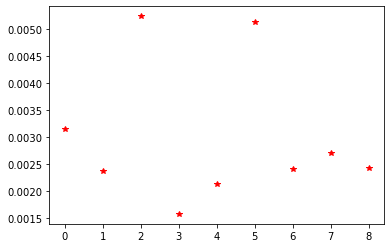

In [7]:
plt.plot(Norm_delta.T,'r*')
plt.title('Norm deltas for range of latent dimension')
plt.savefig('Results/Norm_delta__vs_Z')
#plt.show()

In [ ]:
plt.plot(Norm_omega.T,'k*')
plt.title('Norm omegas for range of latent dimension')
plt.savefig('Results/Norm_omega__vs_Z')